Final SNN Implementation (Paper-Reproduced)

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, TFBertModel
import arff
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# ==========================
# Step 1: Load data
# ===========================

#step 1 completed

# train_df=pd.read_csv("Datasets/target_train.csv")
# test_df=pd.read_csv("Datasets/target_test.csv")

# sample_matching_df = pairwise_df[pairwise_df['label'] == 1].sample(n=50000, random_state=42)
# sample_nonmatching_df = pairwise_df[pairwise_df['label'] == 0].sample(n=50000, random_state=42)
# sample_df = pd.concat([sample_matching_df, sample_nonmatching_df]).reset_index(drop=True)

# # Optionally, print sample_df to inspect
# print("Sampled record pairs:")
# print(sample_df[['uid1', 'uid2', 'label']].head())

In [4]:
# print(train_df.head())

        uid1                                              text1       uid2  \
0  6488772-1  A 38-year-old man presented to our office afte...  7383003-1   
1  6069825-1  A 54-year-old male, with alcohol-related liver...  6069825-2   
2  2740309-1  A 32-year-old man (white, 75 kg, 182 cm and no...  8225499-1   
3  1283745-1  A 59-year-old man was admitted to Coronary Car...  7093274-2   
4  6062634-1  A thirty-two-year-old female patient from Mexi...  8245233-2   

                                               text2  label  
0  A 21 year-old man with an established diagnosi...      0  
1  A 47-year-old male, with alcohol-related liver...      1  
2  A 19-year-old male patient presented with high...      0  
3  A 17-year-old boy was involved in a high-impac...      0  
4  A 49-year-old female with a history of nonalco...      0  


In [ ]:
# Step 3: Generate embeddings only for train and test separately
# import numpy as np
# from transformers import BertTokenizer, TFBertModel
# import tensorflow as tf
# from tqdm import tqdm

# # Load pretrained BERT model and tokenizer
# from transformers import BertTokenizer, TFBertModel

# # Load ClinicalBERT
# tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
# bert_model = TFBertModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")


# # Helper function for batched embedding generation
# def generate_embeddings_batched(texts, batch_size=32, max_length=512):
#     all_embeddings = []

#     for i in range(0, len(texts), batch_size):
#         batch = texts.iloc[i:i+batch_size].tolist()
#         inputs = tokenizer(
#             batch,
#             return_tensors="tf",
#             padding=True,
#             truncation=True,
#             max_length=max_length  # Truncate to 512 tokens
#         )
#         outputs = bert_model(inputs["input_ids"])
#         cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
#         all_embeddings.append(cls_embeddings.numpy())

#     return np.vstack(all_embeddings)
# # Encode and save embeddings
# x1_train = generate_embeddings_batched(train_df['text1'])
# x2_train = generate_embeddings_batched(train_df['text2'])
# y_train = train_df['label'].values.astype(np.float32)

# x1_test = generate_embeddings_batched(test_df['text1'])
# x2_test = generate_embeddings_batched(test_df['text2'])
# y_test = test_df['label'].values.astype(np.float32)

# step 3 completed

In [15]:
# Directory to store cached files
# os.makedirs("clinicalbert", exist_ok=True)
# # save the embeddings for later use
# np.save("clinicalbert/x1_train.npy", x1_train)
# np.save("clinicalbert/x2_train.npy", x2_train)
# np.save("clinicalbert/y_train.npy", y_train)
# np.save("clinicalbert/x1_test.npy", x1_test)
# np.save("clinicalbert/x2_test.npy", x1_test)
# np.save("clinicalbert/y_test.npy", y_test)

# For the later experiments load the embeddings using following code
x1_train = np.load("embeddings/x1_target_train.npy")
x2_train = np.load("embeddings/x2_target_train.npy")
y_train = np.load("embeddings/y_target_train.npy")
x1_test = np.load("embeddings/x1_target_test.npy")
x2_test = np.load("embeddings/x2_target_test.npy")
y_test = np.load("embeddings/y_target_test.npy")

In [16]:
# ====================================
# Step 3: Build Siamese Autoencoder
# ====================================
from tensorflow.keras import layers, regularizers, Model, Input


def build_siamese_autoencoder(embedding_dim):
    encoder_input = Input(shape=(embedding_dim,))
    x = layers.Dense(50, activity_regularizer=regularizers.l1(0.01))(encoder_input)
    x = layers.LeakyReLU(negative_slope=0.01)(x)
    encoder_output = layers.Dense(embedding_dim)(x)  # Consider linear output
    encoder = Model(encoder_input, encoder_output)

    decoder_input = Input(shape=(embedding_dim,))
    decoder_output = layers.Dense(embedding_dim, activation='sigmoid')(decoder_input)
    decoder = Model(decoder_input, decoder_output)

    input1 = Input(shape=(embedding_dim,))
    input2 = Input(shape=(embedding_dim,))
    encoded1 = encoder(input1)
    encoded2 = encoder(input2)
    recon1 = decoder(encoded1)
    recon2 = decoder(encoded2)

    # Output both encoded and reconstructed vectors
    merged_output = layers.Concatenate()([encoded1, encoded2, recon1, recon2])
    model = Model(inputs=[input1, input2], outputs=merged_output)
    return model, encoder

def hybrid_classification_loss(margin=2.5, alpha=1.0):
    def loss_fn(y_true, y_pred):
        emb_dim = tf.shape(y_pred)[1] // 4
        encoded1 = y_pred[:, :emb_dim]
        encoded2 = y_pred[:, emb_dim:2*emb_dim]
        recon1 = y_pred[:, 2*emb_dim:3*emb_dim]
        recon2 = y_pred[:, 3*emb_dim:]

        # Contrastive loss on encoded vectors
        distances = tf.norm(encoded1 - encoded2, axis=1)
        y_true = tf.cast(y_true, tf.float32)
        contrastive_loss = y_true * tf.square(distances) + (1 - y_true) * tf.square(tf.maximum(margin - distances, 0))

        # True reconstruction loss: input1 vs recon1, input2 vs recon2
        recon_loss1 = tf.reduce_mean(tf.square(encoded1 - recon1), axis=1)
        recon_loss2 = tf.reduce_mean(tf.square(encoded2 - recon2), axis=1)
        recon_loss = 0.5 * (recon_loss1 + recon_loss2)

        return tf.reduce_mean(alpha * recon_loss + contrastive_loss)
    return loss_fn

embedding_dim = x1_train.shape[1]
sa_model, encoder = build_siamese_autoencoder(embedding_dim)
sa_model.compile(optimizer='adam', loss=hybrid_classification_loss(margin=2.5, alpha=1.0))
sa_model.fit([x1_train, x2_train], y_train, epochs=30, batch_size=256, validation_split=0.1)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 28.6171 - val_loss: 16.3957
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.4741 - val_loss: 12.7353
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 11.9593 - val_loss: 11.0692
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 10.5261 - val_loss: 10.1080
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.6416 - val_loss: 9.3886
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8939 - val_loss: 8.7072
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4023 - val_loss: 8.6148
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9429 - val_loss: 7.9583
Epoch 9/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.6505 - val_loss: 7.6913
Epoch 10/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.2594 - val_loss: 7.1162
Epoch 11/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.0230 - val_loss: 6.9806
Epoch 12/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [14]:
# ==========================================================
# Evaluate the Siamese Autoencoder (Threshold-based)
# ==========================================================

# Get reconstructions
encoded1_train = encoder.predict(x1_train)
encoded2_train = encoder.predict(x2_train)
encoded1_test = encoder.predict(x1_test)
encoded2_test = encoder.predict(x2_test)

# Compute Euclidean distances
train_distances = np.sqrt(np.sum((encoded1_train - encoded2_train)**2, axis=1))
test_distances = np.sqrt(np.sum((encoded1_test - encoded2_test)**2, axis=1))

# Use fixed threshold (e.g., 1.0) to classify matches
threshold = 1.0
train_pred = (train_distances < threshold).astype(int)
test_pred = (test_distances < threshold).astype(int)

# Accuracy & F1
train_acc = accuracy_score(y_train, train_pred)
train_f1 = f1_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)
test_f1 = f1_score(y_test, test_pred)

print("------ Siamese Autoencoder Evaluation ------")
print(f"Training Accuracy: {train_acc:.4f}, F1 Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, F1 Score: {test_f1:.4f}")


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
------ Siamese Autoencoder Evaluation ------
Training Accuracy: 0.8141, F1 Score: 0.7962
Test Accuracy: 0.7991, F1 Score: 0.7794


In [16]:
# ====================================
# Step 4: Add Classification Head
'''
A small feed-forward network (MLP) takes the difference vector as input.
Learns non-linear interactions between embedding dimensions.
Outputs a probability of match using sigmoid
'''
# ====================================
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate

# Step 1: Get encoded outputs
encoded1_train = encoder.predict(x1_train)
encoded2_train = encoder.predict(x2_train)
encoded1_test = encoder.predict(x1_test)
encoded2_test = encoder.predict(x2_test)

# Step 2: Compute absolute differences (Siamese-style)
diff_train = np.abs(encoded1_train - encoded2_train)
diff_test = np.abs(encoded1_test - encoded2_test)

# Step 3: Build classification model
input_diff = Input(shape=(diff_train.shape[1],))
x = Dense(64, activation='relu')(input_diff)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
clf_model = Model(inputs=input_diff, outputs=output)

clf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the classifier
clf_model.fit(diff_train, y_train, epochs=20, batch_size=256, validation_split=0.1)

# Step 5: Evaluate
y_pred_prob = clf_model.predict(diff_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

from sklearn.metrics import accuracy_score, f1_score, classification_report

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# print("\nClassifier Evaluation:")
# print(f"Accuracy: {acc:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print("\nDetailed report:\n", classification_report(y_test, y_pred))


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7240 - loss: 0.5147 - val_accuracy: 0.7994 - val_loss: 0.4538
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8271 - loss: 0.3940 - val_accuracy: 0.8097 - val_loss: 0.4458
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8333 - loss: 0.3790 - val_accuracy: 0.8044 - val_loss: 0.4488
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8356 - loss: 0.3767 - val_accuracy: 0.8041 - val_loss: 0.4291
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8365 - loss: 0.3741 - val_accuracy: 0.8084 - val_loss: 0.4276
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8382 - loss: 0.3695 - val_accuracy: 0.8119 - val_loss: 0.4269
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - ac

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
Classifier Accuracy: 0.813875
Classifier F1 Score: 0.8175915717260811
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.79      0.81      4008
         1.0       0.80      0.84      0.82      3992

    accuracy                           0.81      8000
   macro avg       0.81      0.81      0.81      8000
weighted avg       0.81      0.81      0.81      8000



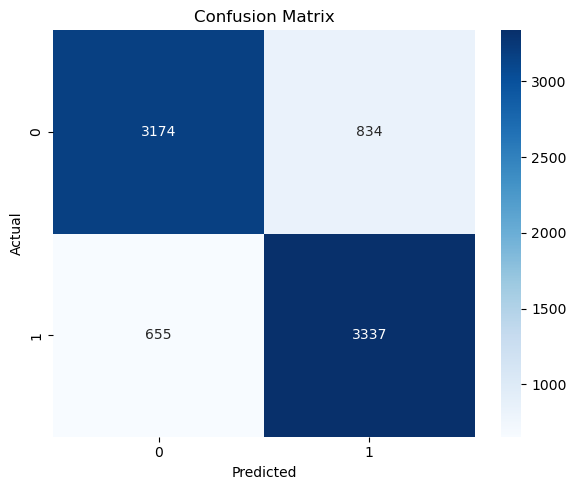

In [17]:
# ====================================
# Step 5: Evaluation and Visualization
# ====================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = clf_model.predict(diff_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classifier Accuracy:", acc)
print("Classifier F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# Save Model
#clf_model.save("snn_classifier_model.h5")

In [20]:
print("Train label distribution:")
print(pd.Series(y_train).value_counts())


Train label distribution:
0.0    16031
1.0    15969
Name: count, dtype: int64


In [36]:
# =========================================
# Learn threshold using raw BERT embeddings
# =========================================

from tensorflow.keras.layers import Dropout
from sklearn.metrics import precision_recall_fscore_support

# -------------------------------------------------------
# Step 1: Compute absolute differences from raw BERT embeddings
# -------------------------------------------------------

X_train_full = np.abs(x1_train - x2_train)
X_test = np.abs(x1_test - x2_test)

# -------------------------------------------------------
# Step 2: Create pseudo-validation split
# -------------------------------------------------------

X_train_final, X_val, y_train_final, y_val = train_test_split(
X_train_full, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# -------------------------------------------------------
# Step 3: Build and Train MLP Classifier
# -------------------------------------------------------

input_dim = X_train_final.shape[1]
input_layer = Input(shape=(input_dim,))
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
output = Dense(1, activation='sigmoid')(x)

clf_model = Model(inputs=input_layer, outputs=output)
clf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

clf_model.fit(X_train_final, y_train_final, epochs=30, batch_size=256, validation_split=0.1)
# clf_model.save("mlp_raw_diff_classifier.h5")

# -------------------------------------------------------
# Step 4: Tune threshold on validation set
# -------------------------------------------------------

y_val_prob = clf_model.predict(X_val).flatten()

best_threshold = 0.5
best_f1 = 0

for threshold in np.arange(0.1, 0.9, 0.01):
    y_pred_val = (y_val_prob >= threshold).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_val, y_pred_val, average='binary')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold (on pseudo-val set): {best_threshold:.2f} — Best F1 Score: {best_f1:.4f}")

# -------------------------------------------------------
# Step 5: Evaluate on true test set using tuned threshold
# -------------------------------------------------------

y_test_prob = clf_model.predict(X_test).flatten()
y_test_pred = (y_test_prob >= best_threshold).astype(int)

acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("\nFinal Evaluation on Test Set:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nDetailed Report:\n", classification_report(y_test, y_test_pred))

# Save predictions
pd.DataFrame({
"True Label": y_test,
"Predicted Label": y_test_pred,
"Confidence": y_test_prob
}).to_csv("final_test_predictions_raw_mlp.csv", index=False)
print("Test predictions saved to 'final_test_predictions_raw_mlp.csv'")


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7350 - loss: 1.3016 - val_accuracy: 0.8340 - val_loss: 0.7269
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8479 - loss: 0.6085 - val_accuracy: 0.8809 - val_loss: 0.4833
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8676 - loss: 0.4670 - val_accuracy: 0.8781 - val_loss: 0.4135
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8755 - loss: 0.4116 - val_accuracy: 0.8707 - val_loss: 0.4034
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8777 - loss: 0.3897 - val_accuracy: 0.8813 - val_loss: 0.3726
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8707 - loss: 0.3871 - val_accuracy: 0.8938 - val_loss: 0.3557
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8789 - loss: 0.3713 - val_accuracy: 0.8832 - val_loss: 0.3623
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8787 - loss: 0.3668 - val_accuracy: 0.8957 - val_loss: